In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt

import gsw as sw

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [14]:
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

In [2]:
# import data directly from myria

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-particle_stats_byfile/data?format=csv'
result = pd.read_csv(fileURL)
# pick out the subset of variables to use for clustering/PCA
print result.columns

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-all_sds_v2/data?format=csv'
sds = pd.read_csv(fileURL)
sds.rename(columns={'file': 'File_Id', 'day': 'Day'}, inplace=True)
print sds.columns


Index([u'fsc_avg', u'fsc_var', u'chl_avg', u'chl_var', u'pe_avg', u'pe_var', u'Cruise', u'Day', u'File_Id'], dtype='object')
Index([u'Day', u'LAT', u'LON', u'File_Id', u'T', u'S', u'Cruise'], dtype='object')


In [3]:
# join sds dataframe to opp file averages

print sds.shape
#print type(sds), type(cIdx[9])
new_table = pd.merge(sds, result, how="inner")


#X = new_table[['fsc_avg','chl_avg','pe_avg','fsc_var','chl_var','pe_var']].values  
X = new_table[['fsc_avg','chl_avg','pe_avg']].values 

(69235, 7)


In [110]:
# identify continuous transects
# start by just picking out cruises that we know fit the bill

# look at how the clusters relate to physical properties of the water column...

cr = 'Tokyo_3'
crsub = new_table[(new_table['Cruise']==cr)].sort(['Day','File_Id'],ascending=[1,1])
crsub['density'] = sw.rho(crsub['S'].values,crsub['T'].values,0)

cxx = (crsub['LON']).values # longitude
cyy = (crsub['LAT']).values # latitude

# convert all longitude to longitude east
cxx[cxx<0]= 360+cxx[cxx<0];
cxbew = cxx
cxbew[cxbew>180] = cxbew[cxbew>180]-360

# calculate distance between points
cdistance = sw.distance(cxbew,cyy, 0)[0]
ctrack = np.cumsum(cdistance)
ctrack = np.insert(ctrack, 0, 0)

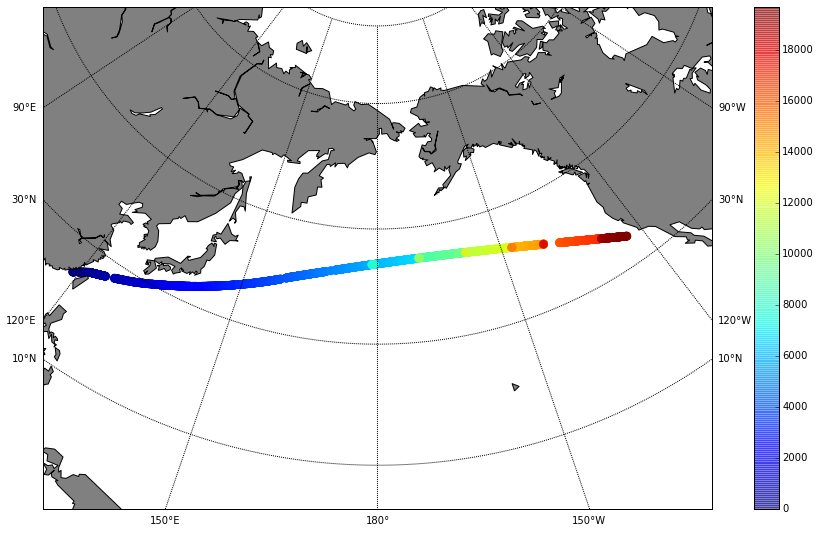

[ 1.38815721  1.39729804  1.38548337 ...,  1.50362189  1.49488258
  1.49392785]


In [128]:
# plot the cruise track

fig1 = plt.figure(1, figsize=(15,9))

m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=15.,lat_2=60,lat_0=45,lon_0=-180.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
#plt.axes([0.025, 0.025, 0.95, 0.95])
xm, ym = m(cxbew,cyy)
m.scatter(xm, ym, s=75, c=ctrack/1000, alpha=.5,lw=0)

m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])


plt.tick_params(axis='both', which='major', labelsize=16)
plt.colorbar()
plt.show()

print cdistance/1000

In [112]:
inds = indices(cdistance, lambda x: x > 10000)
print cdistance[inds]/1000
print inds
print max(cyy)
print len(inds), len(cdistance)
print ctrack[inds]/1000
print ctrack[-1]/1000
print np.mean(cdistance)/1000

[   81.43814635   168.74869405    12.20514823    13.56630768    13.67974912
    13.04347408    10.57173303    11.73915579    30.07941928    15.24737626
    32.23461215    45.31524917    15.23028686    16.33253939    97.98814373
    84.67939531    81.72950512    81.33013955   911.35620751   907.78653609
    11.22770384   899.47535427   898.58614112   908.19647106   950.8797072
   622.47152715   914.34055802  1106.90551225  1129.49698467]
[23, 394, 482, 497, 498, 509, 600, 603, 643, 660, 1060, 1506, 1584, 1676, 1943, 2373, 2379, 2701, 3139, 3164, 3165, 3612, 3627, 4095, 4096, 4553, 4563, 5020, 5024]
44.59235
29 5352
[    32.45132351    636.55414416    970.50521895   1025.74004324
   1039.30635092   1086.60489968   1296.43392393   1310.90031926
   1431.2520547    1512.01590231   2277.95939849   3148.57322119
   3340.4148931    3535.08735692   4038.69638678   4930.53536834
   5024.59154482   5819.8573227    6733.45034587   7700.31820224
   8608.10473833   9457.77301105  10383.33057302  121

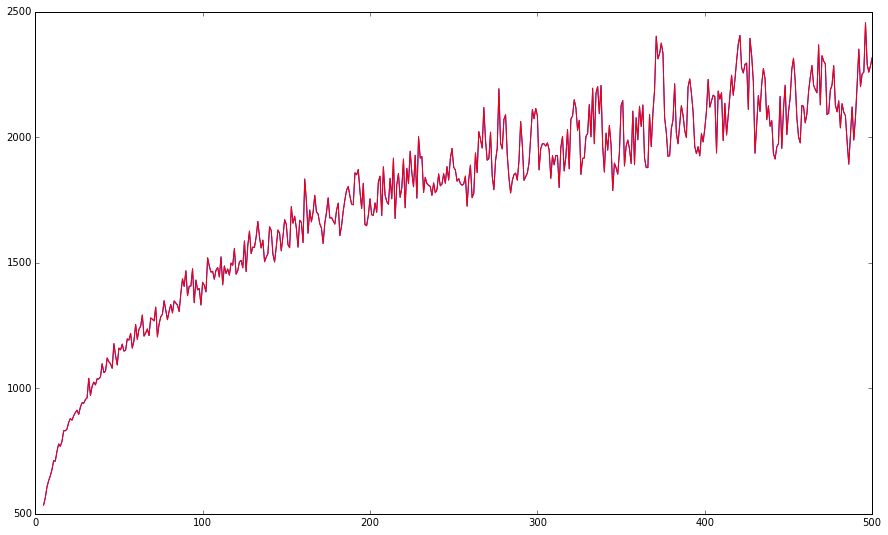

In [144]:
# interpolate the data onto progressively coarser grids
# use linear interpolation from 5km to 500km
dx = np.arange(5,501,1)
inter_x = np.zeros((len(dx), len(ctrack)))
rmse = np.zeros((len(dx), 1))
mae = np.zeros((len(dx), 1))
var = crsub['fsc_avg']

for d in range(0,len(dx)):
    inter_range = np.arange(ctrack[0],ctrack[-1],dx[d])*1000
    inter_var = np.interp(inter_range, ctrack, var)
    inter_x[d,:] = np.interp(ctrack,inter_range,inter_var)
    rmse[d] = np.mean(np.sqrt((inter_x[d,:]-var)**2))
    mae[d] = np.mean(abs(inter_x[d,:]-var))
    
fig2 = plt.figure(2, figsize=(15,9))
plt.plot(dx, rmse, dx,mae,'-r')
plt.show()

a = 2045.12258285 , b = 78.7341547674


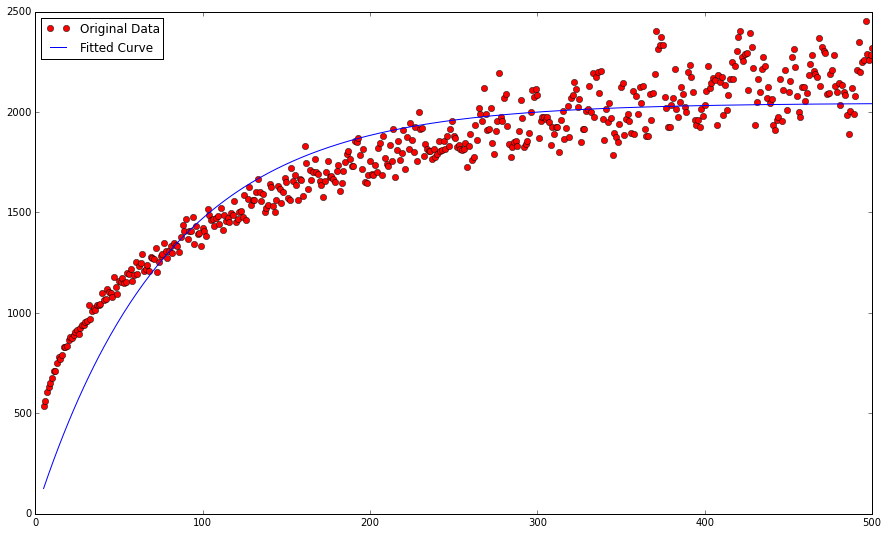

In [146]:
# try to fit a curve to the data
from scipy.optimize import curve_fit


x = [float(xn) for xn in dx] #every element (xn) in x becomes a float
y = [float(yn) for yn in mae] #every element (yn) in y becomes a float
x = np.array(x) #transform your data in a numpy array, 
y = np.array(y)


def func(x, a, b):
     return a * (1 - np.exp(-x/b))

popt, pcov = curve_fit(func, x, y)

print "a = %s , b = %s" % (popt[0], popt[1])


fig3 = plt.figure(3, figsize=(15,9))
plt.plot(x, y, 'ro',label="Original Data")
plt.plot(x, func(x, *popt), label="Fitted Curve") 

plt.legend(loc='upper left')
plt.show()

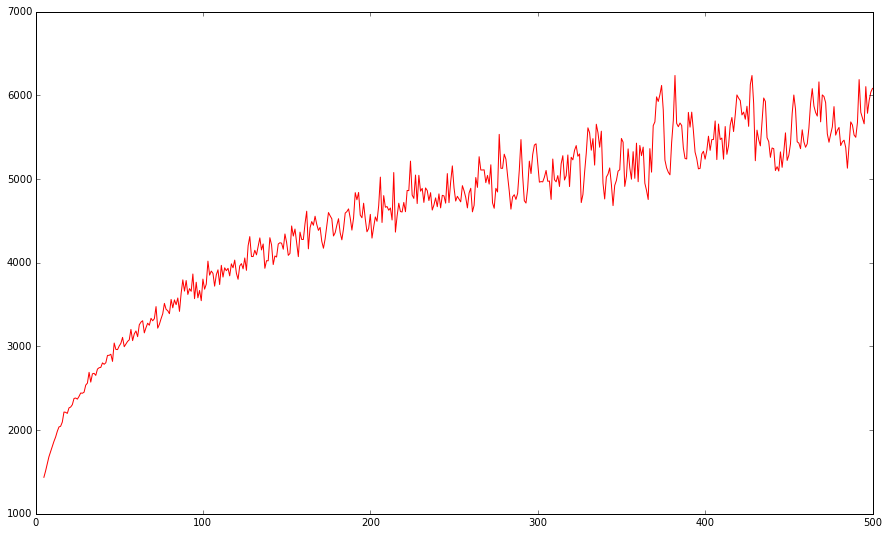

In [150]:
# now try to do this for a 3D array of opp variables

# interpolate the data onto progressively coarser grids
# use linear interpolation from 5km to 500km
dx = np.arange(5,501,1)
inter_x1 = np.zeros((len(dx), len(ctrack)))
inter_x2 = np.zeros((len(dx), len(ctrack)))
inter_x3 = np.zeros((len(dx), len(ctrack)))

mae = np.zeros((len(dx), 1))
var1 = crsub['fsc_avg']
var2 = crsub['chl_avg']
var3 = crsub['pe_avg']


for d in range(0,len(dx)):
    inter_range = np.arange(ctrack[0],ctrack[-1],dx[d])*1000
    inter_var1 = np.interp(inter_range, ctrack, var1)
    inter_var2 = np.interp(inter_range, ctrack, var2)
    inter_var3 = np.interp(inter_range, ctrack, var3)
    inter_x1[d,:] = np.interp(ctrack,inter_range,inter_var1)
    inter_x2[d,:] = np.interp(ctrack,inter_range,inter_var2)
    inter_x3[d,:] = np.interp(ctrack,inter_range,inter_var3)
    
    mae[d] = np.mean((abs(inter_x1[d,:]-var1))+(abs(inter_x2[d,:]-var2))+(abs(inter_x3[d,:]-var3)))
    
fig2 = plt.figure(2, figsize=(15,9))
plt.plot(dx,mae,'-r')
plt.show()

a = 4591.49204599 , b = 0.191173876179


/Users/sclayton/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


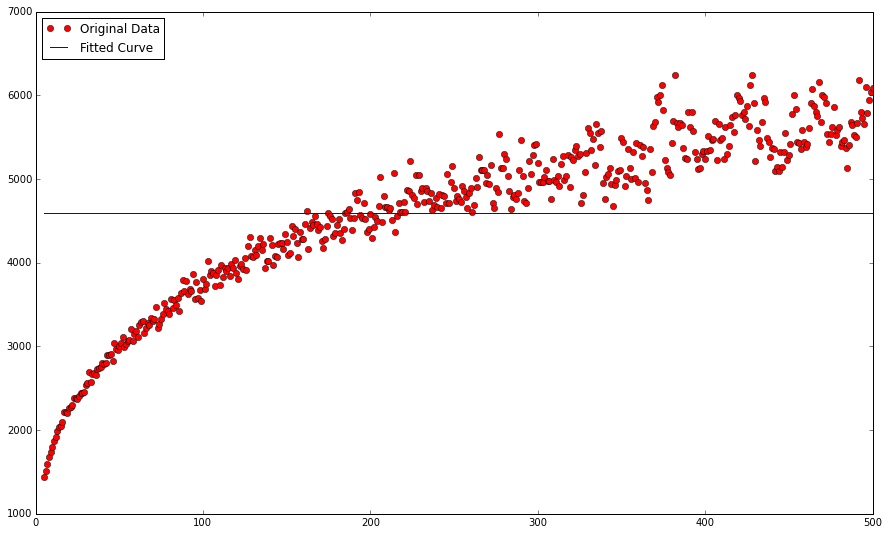

In [151]:
# try to fit a curve to the data
from scipy.optimize import curve_fit

x = [float(xn) for xn in dx] #every element (xn) in x becomes a float
y = [float(yn) for yn in mae] #every element (yn) in y becomes a float
x = np.array(x) #transform your data in a numpy array, 
y = np.array(y)


def func(x, a, b):
     return a * (1 - np.exp(-x/b))

popt, pcov = curve_fit(func, x, y)

print "a = %s , b = %s" % (popt[0], popt[1])


fig3 = plt.figure(3, figsize=(15,9))
plt.plot(x, y, 'ro',label="Original Data")
plt.plot(x, func(x, *popt), label="Fitted Curve") 

plt.legend(loc='upper left')
plt.show()